In [2]:
import IPython
from IPython.display import Image, Audio, Video
import music21 as ms
from midi2audio import FluidSynth
import tensorflow 
import numpy as np 
import pandas as pd 
from collections import Counter
import sys
from sklearn.model_selection import train_test_split
import warnings
import os
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
from tensorflow.keras.callbacks import ModelCheckpoint
import time

Referências:<br/>
https://web.mit.edu/music21/doc/usersGuide/usersGuide_15_key.html<br/>
https://www.kaggle.com/code/karnikakapoor/music-generation-lstm#LOADING-DATA

## Introdução ao pacote music21

In [ ]:
ms.environment.set('musescoreDirectPNGPath', 'C:/Program Files/MuseScore 3/bin/MuseScore3.exe')
ms.environment.UserSettings()['lilypondPath'] = 'C:/Program Files (x86)/LilyPond/usr/bin'

In [ ]:
n = ms.note.Note('A#3')
n.duration.type = 'half'
n.show()

In [ ]:
n.duration, n.name, n.octave, n.pitch, n.pitch.frequency

In [ ]:
n.pitch.accidental, n.pitch.alter, n.pitch.midi

In [ ]:
n.myAttribute = "step by step we'll still play Chopin"

In [ ]:
print(n.myAttribute)

In [ ]:
r = ms.note.Rest()

In [ ]:
r.duration.type = 'half'

In [ ]:
r.show()

In [ ]:
p1 = ms.pitch.Pitch('F#5')

In [ ]:
print(p1.octave)
print(p1.name)
print(p1.nameWithOctave)
print(p1.accidental)
print(p1.midi)
print(p1.spanish)
print(p1.getEnharmonic())

In [ ]:
n = ms.note.Note('A#3')
print('whole')
n.duration.type = 'whole'
n.show()

print('half')
n.duration.type = 'half'
n.show()

print('quarter')
n.duration.type = 'quarter'
n.show()

print('eighth')
n.duration.type = 'eighth'
n.show()

In [ ]:
n = ms.note.Note('F-3')
n.duration = ms.duration.Duration(0.5)
print(n.duration.type)
n.show()

n.duration = ms.duration.Duration(1)
print(n.duration.type)
n.show()

n.duration = ms.duration.Duration(2)
print(n.duration.type)
n.show()

n.duration = ms.duration.Duration(4)
print(n.duration.type)
n.show()


In [ ]:
n.addLyric('Lyric')
n.show()

### Notes lists, streams and outputs

In [ ]:
n1 = ms.note.Note(nameWithOctave='c3', duration=ms.duration.Duration(1))
n2 = ms.note.Note(nameWithOctave='d#3', duration=ms.duration.Duration(2))
n3 = ms.note.Note(nameWithOctave='g3', duration=ms.duration.Duration(1))
n4 = ms.note.Note(nameWithOctave='a3', duration=ms.duration.Duration(4))
noteList = [n1, n2, n3]
print(noteList)

In [ ]:
noteList.append(n4)
for note in noteList:
    print(note.name)

In [ ]:
stream1 = ms.stream.Stream()
stream1.append(n1)
stream1.append(n2)
stream1.append(n3)
stream1.repeatAppend(n4, 3)

print('Stream length: {}'.format(len(stream1)))
stream1.show('text')
stream1.show()
stream1.show('midi')

In [ ]:
for note in stream1:
    print(note.nameWithOctave)

In [ ]:
n1 = ms.note.Note(nameWithOctave='g3', duration=ms.duration.Duration(2))
n2 = ms.note.Note(nameWithOctave='b3', duration=ms.duration.Duration(2))
n3 = ms.note.Note(nameWithOctave='d4', duration=ms.duration.Duration(2))
n4 = ms.note.Note(nameWithOctave='g4', duration=ms.duration.Duration(2))
r1 = ms.note.Rest(duration=ms.duration.Duration(2))
r2 = ms.note.Rest(duration=ms.duration.Duration(2))

stream2 = ms.stream.Stream([n1, n2])
stream2.append(r1)
stream2.append([n3, n4])
stream2.append(r2)

stream2[0].offset = 0.0
stream2[1].offset = 0.0
stream2[2].offset = 2.0
stream2[3].offset = 4.0
stream2[4].offset = 4.0
stream2[5].offset = 6.0

print('Stream length: {}'.format(len(stream1)))
stream2.show('text')
stream2.show()
stream2.show('midi')

In [ ]:
stream2.analyze('ambitus')

In [ ]:
stream2.lowestOffset, stream2.highestOffset, stream2.highestTime

In [ ]:
ms.defaults.meterNumerator = 3
ms.defaults.meterDenominatorBeatType = 6
stream2.show()

In [ ]:
s = ms.stream.Score(id='mainScore')
p0 = ms.stream.Part(id='part0')
p1 = ms.stream.Part(id='part1')
p2 = ms.stream.Part(id='part2')

m01 = ms.stream.Measure(number=1)
m01.append(ms.note.Note('C-3', type="whole"))
m01.append(ms.note.Note('E#4', type="whole"))
m02 = ms.stream.Measure(number=2)
m02.append(ms.note.Note('D5', type="whole"))
p0.append([m01, m02])

m11 = ms.stream.Measure(number=1)
m11.append(ms.note.Note('E2', type="whole"))
m12 = ms.stream.Measure(number=2)
m12.append(ms.note.Note('F3', type="whole"))
p1.append([m11, m12])

m20 = ms.stream.Measure(number=1)
m20.append(ms.note.Note('E#3', type="whole"))
p2.append(m20)

s.insert(0, p0)
s.insert(0, p1)
s.insert(0, p2)
s.show('text')
s.show()
s.show('midi')

In [ ]:
for el in s.recurse():
    if isinstance(el, ms.note.Note):
        print(el.offset, el, el.activeSite)

In [ ]:
print('1st treble clef')
for measure in s[0]:
    for note in measure:
        print('offset:{} - name{}'.format(note.offset, note.nameWithOctave))
        
print('2nd treble clef') #bassclef     
for measure in s[1]:
    for note in measure:
        print('offset:{} - name{}'.format(note.offset, note.nameWithOctave))

In [ ]:
for measure in s:
    print(s.flatten())

### Chords

In [ ]:
cMinor = ms.chord.Chord(["C5","G4","E-5"])
cMinor.duration = ms.duration.Duration(4)
cMinor.show()

In [ ]:
for pitch in cMinor.pitches:
    print(pitch.nameWithOctave)

In [ ]:
cMinor.isMajorTriad(), cMinor.isMinorTriad()

In [ ]:
cMinor.isMajorTriad()

In [ ]:
print('is chord?: {}'.format(cMinor.isChord))
print('Common name: {}'.format(cMinor.commonName))
print('Full name: {}'.format(cMinor.fullName))
print('Pitch common name: {}'.format(cMinor.pitchedCommonName))
print('inversion: {}'.format(cMinor.inversion()))
print('chord root: {}'.format(cMinor.root()))
print('chord third: {}'.format(cMinor.third))
print('chord fifth: {}'.format(cMinor.fifth))
print('chord seventh: {}'.format(cMinor.seventh))
print('chord bass: {}'.format(cMinor.bass()))

In [ ]:
cMinor.add('c6')
cMinor.show()

In [ ]:
cClosed = cMinor.closedPosition()
cClosed.show()

In [ ]:
streamC = ms.stream.Stream()
streamC.append(cMinor)
streamC.append(ms.chord.Chord(['g4', 'b-4', 'd5']))
streamC.append(ms.chord.Chord(['a3', 'c4', 'e4']))
streamC.show()

In [ ]:
rest1 = ms.note.Rest()
rest1.quarterLength = 0.5
noteASharp = ms.note.Note('A#5')
noteASharp.quarterLength = 1.5

stream2 = ms.stream.Stream()
stream2.append(cMinor)
stream2.append(rest1)
stream2.append(noteASharp)
stream2.show()

In [ ]:
#Load from midi file
song = ms.converter.parse('data/debussy/DEB_CLAI.mid')

score = ms.stream.Stream()
score.append(song)

print('Show sheet and midi player')
song.show(), song.show('midi') 

In [ ]:
songTemp = ms.stream.Stream([song[0], song[1]]) #just treble and bass clefs

songTemp.show('text')

In [ ]:
songChordify = song.chordify()
print('Show sheet and midi player')
song.show(), song.show('midi') 

In [ ]:
#Twinkle Twinkle Little Star
littleMelody = converter.parse('tinynotation: 4/4 c4 c4 g4 g4 a4 a4 g2 f4 f4 e4 e4 d4 d4 c2')
#Symphony 5 1st Movement
littleMelody = converter.parse('tinynotation: 2/4 g8 g8 g8 e-1 f8 f8 f8 d1 g8 g8 g8 e-8 a-8 a-8 a-8 g8 e-8 e-8 e-8 c1')
#Load from midi file
#littleMelody = converter.parse('data/mozart/mz_545_1.mid')

score = stream.Stream()
score.append(note.Rest())
score.append(littleMelody)
print('Show sheet and midi player')
littleMelody.show(), littleMelody.show('midi') 

In [ ]:
#Salvar arquivo para formato musicxml
stream.Stream.write(littleMelody, fp='output')

In [ ]:
#Exibir somente trecho específico do arquivo.
littleMelody.measures(1, 5).show()

In [ ]:
#Converter arquivo midi para outros formatos (wav ou mp3)
fs = FluidSynth(sound_font='FluidR3_GM.sf2')
file = 'data/bach/bach_846.mid'
fs.midi_to_audio(file, 'bach_846.wav')
IPython.display.Audio("bach_846.wav") 

## Loading Files

In [3]:
#Loading the list of chopin's midi files as stream 
filepath = "data/debussy/"
#Getting midi files
all_midis= []
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        tr = filepath+i
        midi = ms.converter.parse(tr)
        all_midis.append(midi)

C:\ProgramData\Anaconda3\lib\site-packages\music21\midi\translate.py:883: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2010 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\music21\midi\translate.py:883: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 1998 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\music21\midi\translate.py:883: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 1998 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


In [6]:
len(all_midis)

7

In [8]:
all_midis[2].show('midi')

In [9]:
#Helping function        
def extract_notes(file):
    notes = []
    pick = None
    for song in file:
        #songs = ms.instrument.partitionByInstrument(j)
        
        for part in song.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, ms.note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, ms.chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))
        
        print(song)
    return notes
#Getting the list of notes as Corpus
Corpus= extract_notes(all_midis)
print("Total notes in all the midis in the dataset:", len(Corpus))

<music21.stream.Score 0x21b502c9be0>
<music21.stream.Score 0x21b50b0b370>
<music21.stream.Score 0x21b50aa7b50>
<music21.stream.Score 0x21b51502af0>
<music21.stream.Score 0x21b51a4b6d0>
<music21.stream.Score 0x21b53f1ad30>
<music21.stream.Score 0x21b54202760>
Total notes in all the midis in the dataset: 7551


In [14]:
print(Corpus[0:150])

['G3', 'C4', 'D4', 'E4', 'G3', 'C4', 'E4', 'D4', 'F3', 'C4', 'D4', 'F4', 'A3', 'B3', 'F4', 'E4', 'G3', 'C4', 'E4', 'G4', 'B3', 'C4', 'G4', 'F4', 'A3', 'C4', 'F4', 'A4', 'B3', 'F4', 'A4', 'G4', 'C4', 'E4', 'G4', 'C5', 'E4', 'G4', 'C5', 'D5', 'E4', 'G4', 'D5', 'C5', 'E4', 'G4', 'C5', 'B4', 'E4', 'G4', 'B4', 'A4', 'E4', 'G4', 'A4', 'G4', 'C4', 'E4', 'G4', 'F4', 'C4', 'E4', 'F4', 'E4', 'B3', 'C4', 'E4', 'D4', 'A3', 'C4', 'D4', 'G4', 'B3', 'E4', 'G4', 'A4', 'C4', 'E4', 'A4', 'E4', 'A3', 'C4', 'E4', 'D4', 'A3', 'C4', 'D4', 'C4', 'G3', 'A3', 'C4', 'B3', 'F3', 'G3', 'B3', 'E3', 'G#3', 'G#3', 'B3', 'B3', 'E4', 'E4', 'G#4', 'A4', 'F4', 'D4', 'F4', 'D4', 'B3', 'A4', 'F4', 'D4', 'F4', 'D4', 'B3', 'C5', 'A4', 'F4', 'A4', 'F4', 'D4', 'F4', 'D4', 'B3', 'D4', 'B3', 'G3', 'A4', 'F4', 'D4', 'F4', 'D4', 'B3', 'A4', 'F4', 'D4', 'F4', 'D4', 'B3', 'C5', 'A4', 'F4', 'A4', 'F4', 'D4', 'F4', 'D4', 'B3', 'D4', 'B3']


In [11]:
chord = ms.chord.Chord(["C3","E3","C2", "G3"])
chord

<music21.chord.Chord C3 E3 C2 G3>

In [12]:
chord.normalOrder

[0, 4, 7]

In [13]:
chord.notes[0] #nameWithOctave

<music21.note.Note C>

## Data Exploration

In [15]:
#First Lets write some functions that we need to look into the data
def show(music):
    display(Image(str(music.write("lily.png"))))
    
def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = [] 
            for j in chord_notes:
                inst_note=int(j)
                note_snip = ms.note.Note(inst_note)            
                notes.append(note_snip)
                chord_snip = ms.chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else: 
            note_snip = ms.note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = ms.stream.Stream(Melody)   
    return Melody_midi

Melody_Snippet = chords_n_notes(Corpus[:100])
#show(Melody_Snippet)

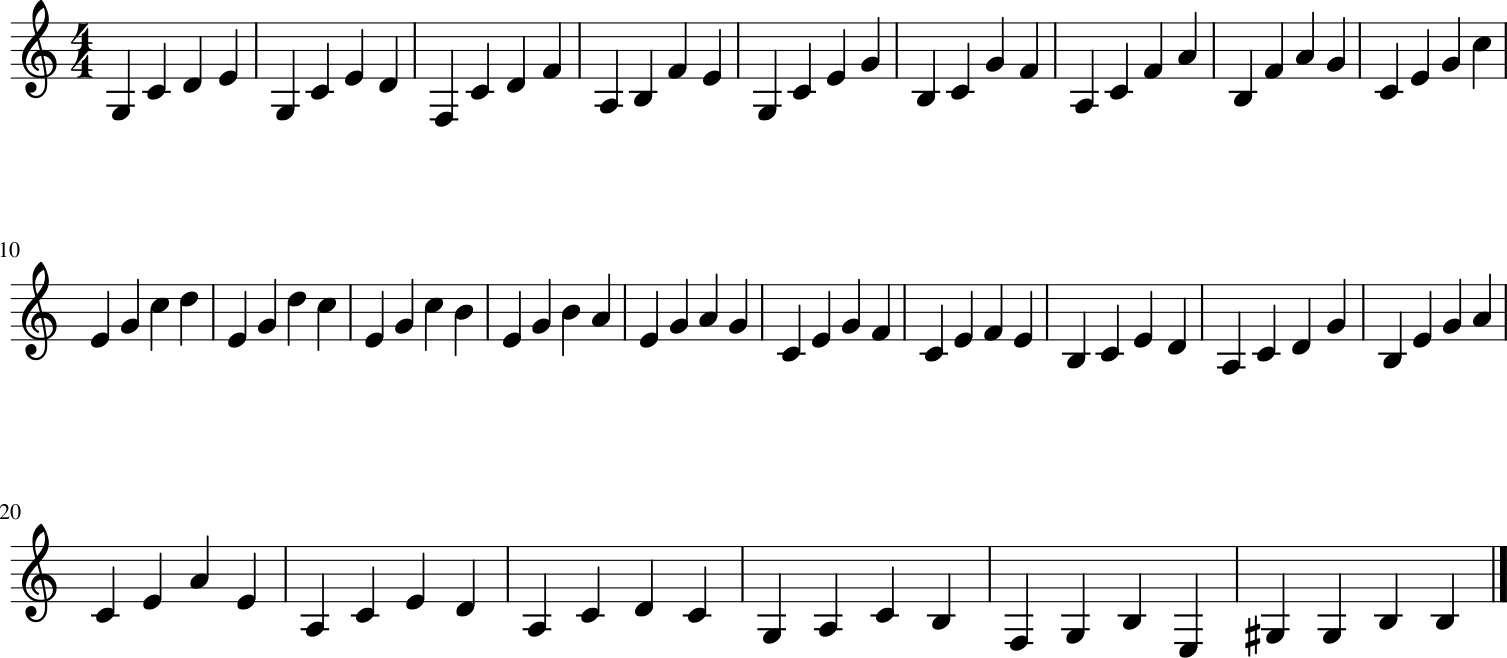

In [16]:
Melody_Snippet.show('midi')
Melody_Snippet.show()

In [17]:
#Creating a count dictionary
count_num = Counter(Corpus)
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 235


In [18]:
#Exploring the notes dictionary
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
#Average recurrenc for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrenc for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrenc for a note in Corpus: 32.13191489361702
Most frequent note in Corpus appeared: 293 times
Least frequent note in Corpus appeared: 1 time


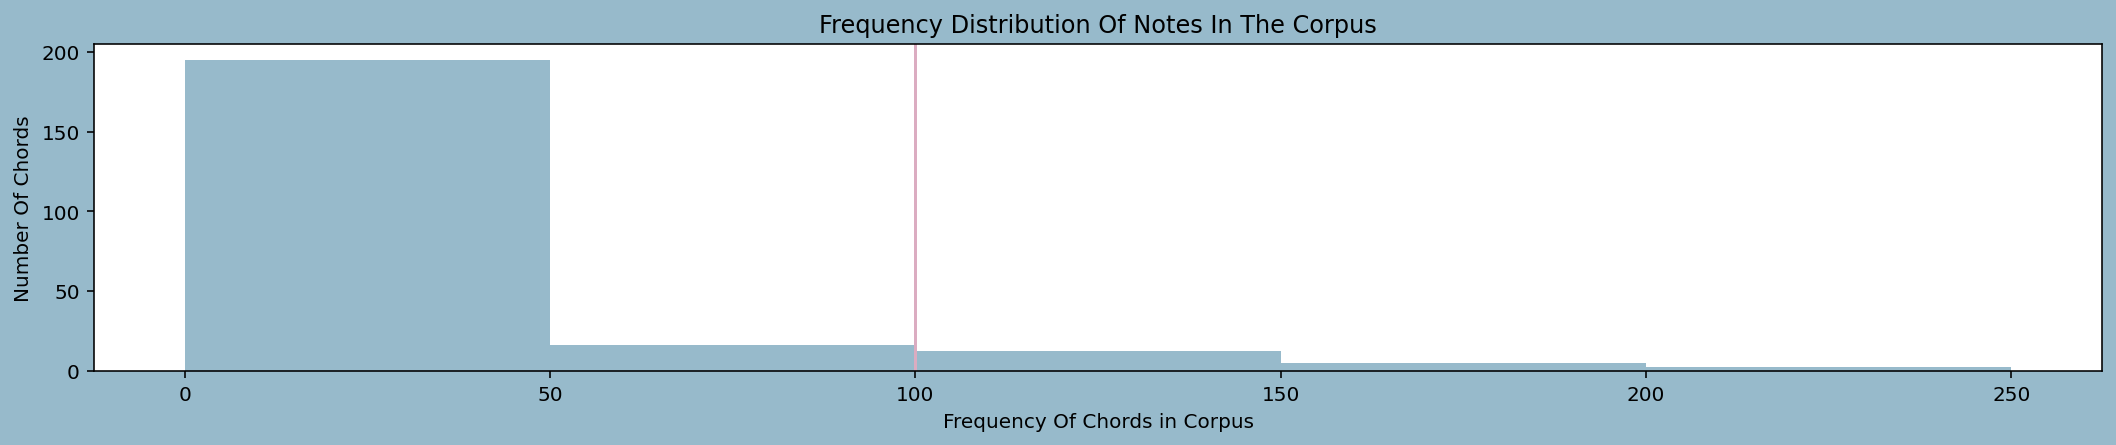

In [19]:
# Plotting the distribution of Notes
plt.figure(figsize=(18,3),facecolor="#97BACB")
bins = np.arange(0,(max(Recurrence)), 50) 
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=100,color="#DBACC1")
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()

I have decided, I will be taking out the notes that were played less than 100 times. I mean, if Chopin liked them he would have played it a lot more often. So I create a list of rare notes in the next section.

In [20]:
#Getting a list of rare chords
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)
        
print("Total number of notes that occur less than 100 times:", len(rare_note))

Total number of notes that occur less than 100 times: 211


In [21]:
#Eleminating the rare notes
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

print("Length of Corpus after elemination the rare notes:", len(Corpus))

Length of Corpus after elemination the rare notes: 5526


In [22]:
len(Corpus)

5526

## Data Preprocessing

In [23]:
# Storing all the unique characters present in my corpus to built a mapping dic. 
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 5526
Number of unique characters: 192


In [24]:
symb

['0',
 '0.2',
 '0.2.4',
 '0.2.7',
 '0.3',
 '0.3.7',
 '0.4',
 '0.4.6',
 '0.4.7',
 '0.5',
 '0.6',
 '1.3',
 '1.3.8',
 '1.4',
 '1.4.8',
 '1.5',
 '1.5.8',
 '1.5.9',
 '1.6',
 '10',
 '10.0',
 '10.0.1',
 '10.1',
 '10.1.3',
 '10.2',
 '10.2.3',
 '10.2.4',
 '10.2.5',
 '10.3',
 '11.0',
 '11.0.1',
 '11.0.2',
 '11.0.3',
 '11.1',
 '11.1.5',
 '11.1.6',
 '11.2',
 '11.2.3',
 '11.2.4',
 '11.2.5',
 '11.2.6',
 '11.3',
 '11.3.4',
 '11.3.6',
 '11.4',
 '2.4',
 '2.4.5',
 '2.4.5.7',
 '2.5',
 '2.5.7',
 '2.5.9',
 '2.6',
 '2.6.8',
 '2.6.9',
 '2.7',
 '2.8',
 '3',
 '3.5',
 '3.6',
 '3.6.10',
 '3.6.8.11',
 '3.7',
 '3.7.10',
 '3.8',
 '4',
 '4.5',
 '4.6',
 '4.6.10',
 '4.6.11',
 '4.6.9',
 '4.7',
 '4.7.10',
 '4.7.11',
 '4.8',
 '4.8.11',
 '4.9',
 '5',
 '5.10',
 '5.7',
 '5.7.10',
 '5.8',
 '5.8.0',
 '5.8.11',
 '5.8.9.0',
 '5.9',
 '5.9.0',
 '5.9.11',
 '6.10',
 '6.10.1',
 '6.11',
 '6.7',
 '6.8.1',
 '6.9',
 '6.9.1',
 '6.9.11',
 '7',
 '7.0',
 '7.10',
 '7.10.0',
 '7.10.2',
 '7.11',
 '7.11.2',
 '7.8.11',
 '7.9',
 '7.9.2',
 '8',
 '

In [25]:
mapping

{'0': 0,
 '0.2': 1,
 '0.2.4': 2,
 '0.2.7': 3,
 '0.3': 4,
 '0.3.7': 5,
 '0.4': 6,
 '0.4.6': 7,
 '0.4.7': 8,
 '0.5': 9,
 '0.6': 10,
 '1.3': 11,
 '1.3.8': 12,
 '1.4': 13,
 '1.4.8': 14,
 '1.5': 15,
 '1.5.8': 16,
 '1.5.9': 17,
 '1.6': 18,
 '10': 19,
 '10.0': 20,
 '10.0.1': 21,
 '10.1': 22,
 '10.1.3': 23,
 '10.2': 24,
 '10.2.3': 25,
 '10.2.4': 26,
 '10.2.5': 27,
 '10.3': 28,
 '11.0': 29,
 '11.0.1': 30,
 '11.0.2': 31,
 '11.0.3': 32,
 '11.1': 33,
 '11.1.5': 34,
 '11.1.6': 35,
 '11.2': 36,
 '11.2.3': 37,
 '11.2.4': 38,
 '11.2.5': 39,
 '11.2.6': 40,
 '11.3': 41,
 '11.3.4': 42,
 '11.3.6': 43,
 '11.4': 44,
 '2.4': 45,
 '2.4.5': 46,
 '2.4.5.7': 47,
 '2.5': 48,
 '2.5.7': 49,
 '2.5.9': 50,
 '2.6': 51,
 '2.6.8': 52,
 '2.6.9': 53,
 '2.7': 54,
 '2.8': 55,
 '3': 56,
 '3.5': 57,
 '3.6': 58,
 '3.6.10': 59,
 '3.6.8.11': 60,
 '3.7': 61,
 '3.7.10': 62,
 '3.8': 63,
 '4': 64,
 '4.5': 65,
 '4.6': 66,
 '4.6.10': 67,
 '4.6.11': 68,
 '4.6.9': 69,
 '4.7': 70,
 '4.7.10': 71,
 '4.7.11': 72,
 '4.8': 73,
 '4.8.11': 74,


In [26]:
#Splitting the Corpus in equal length of strings and output target
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 5486


In [27]:
mapping[Corpus[40]] #Que é justamente o nosso target

167

In [28]:
pd.DataFrame(features)

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,151,157,167,151,167,157,151,157,179,128,...,189,152,167,189,152,158,167,189,158,152
1,157,167,151,167,157,151,157,179,128,140,...,152,167,189,152,158,167,189,158,152,167
2,167,151,167,157,151,157,179,128,140,179,...,167,189,152,158,167,189,158,152,167,189
3,151,167,157,151,157,179,128,140,179,167,...,189,152,158,167,189,158,152,167,189,152
4,167,157,151,157,179,128,140,179,167,151,...,152,158,167,189,158,152,167,189,152,141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5481,158,152,136,190,158,152,136,76,150,116,...,97,157,128,135,188,128,135,151,157,179
5482,152,136,190,158,152,136,76,150,116,84,...,157,128,135,188,128,135,151,157,179,188
5483,136,190,158,152,136,76,150,116,84,167,...,128,135,188,128,135,151,157,179,188,178
5484,190,158,152,136,76,150,116,84,167,157,...,135,188,128,135,151,157,179,188,178,85


In [29]:
pd.DataFrame(targets)

,0
0,167
1,189
2,152
3,141
4,167
...,...
5481,188
5482,178
5483,85
5484,85


In [31]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets) 

In [ ]:
y

In [ ]:
#Taking out a subset of data to be used as seed
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
len(X), len(X_train), len(X_seed)

In [ ]:
X.shape, X_train.shape, X_seed.shape

## Model Building

In [ ]:
#Initialising the Model
model = tensorflow.keras.Sequential()
#Adding layers
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training  
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
#Model's Summary               
model.summary()

In [ ]:
# Load checkpoint weights and re-evaluate
#model.load_weights("modelo/modeloV1.h5")

In [ ]:
checkpoint = ModelCheckpoint(
    'modelV1.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)

#Training the Model
history = model.fit(X_train, y_train, batch_size=256, epochs=200, callbacks = [checkpoint])

## Evaluating Model

In [ ]:
#Plotting the learnings 
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4), facecolor="#97BACB")
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

In [ ]:
def Melody_Generator(Note_Count):
    seed = X_seed[np.random.randint(0,len(X_seed)-1)]
    Music = ""
    Notes_Generated=[]
    for i in range(Note_Count):
        seed = seed.reshape(1,length,1)
        prediction = model.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0 #diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(L_symb)   
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated]
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    #Now, we have music in form or a list of chords and notes and we want to be a midi file.
    Melody = chords_n_notes(Music)
    Melody_midi = ms.stream.Stream(Melody)   
    return Music,Melody_midi



#show(Melody)

In [ ]:
#getting the Notes and Melody created by the model
Music_notes, Melody = Melody_Generator(150)
Melody.show('midi')
Melody.show()

In [ ]:
seed = X_seed[np.random.randint(0,len(X_seed)-1)]

In [ ]:
timestr = time.strftime("%Y%m%d-%H%M%S")
nameFile = 'output-' + timestr + '.mid'
outputFolder = 'output/'
Melody.write('midi', fp=os.path.join(outputFolder, nameFile))

In [ ]:
nameFile

In [ ]:
fs = FluidSynth(sound_font='FluidR3_GM.sf2')
file = 'output/' + nameFile
#'output-20220521-170412'
fs.midi_to_audio(file, 'output.wav')
IPython.display.Audio('output.wav') 